# Import and merge

/Users/raj/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


--- Basic Exploration of Telemetry Train ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 516073 entries, 0 to 516072
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   create_dt          516073 non-null  object 
 1   mdm_object_name    516073 non-null  int64  
 2   mdm_model_id       516073 non-null  int64  
 3   lon                516073 non-null  float64
 4   lat                516073 non-null  float64
 5   alt                516073 non-null  int64  
 6   speed_gps          516073 non-null  float64
 7   direction          516073 non-null  float64
 8   accel_forward_nn   516073 non-null  float64
 9   accel_braking_nn   516073 non-null  float64
 10  accel_angular_nn   516073 non-null  float64
 11  accel_vertical_nn  516073 non-null  float64
dtypes: float64(8), int64(3), object(1)
memory usage: 47.2+ MB
None
       mdm_object_name   mdm_model_id           lon           lat  \
count    516073.00000

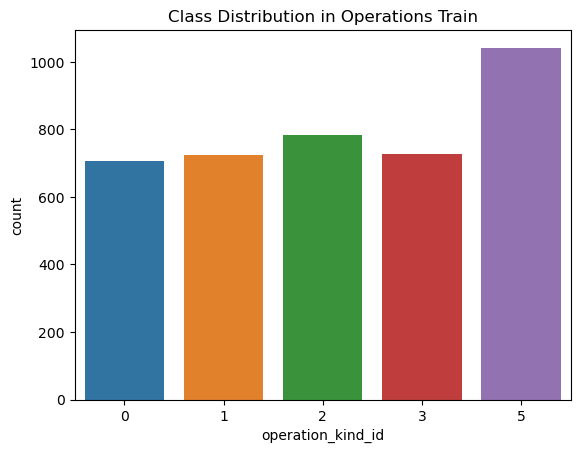

Exploration and feature engineering complete. Processed data saved.


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets

telemetry_train = pd.read_csv('telemetry_for_operations_training.csv')
telemetry_val = pd.read_csv('telemetry_for_operations_validation.csv')
operations_train = pd.read_csv('operations_labels_training.csv')

# Basic Data Exploration
def basic_exploration(df, df_name):
    print(f"--- Basic Exploration of {df_name} ---")
    print(df.info())  # Data types and non-null counts
    print(df.describe())  # Statistical overview of numerical columns
    print("\nMissing values per column:")
    print(df.isnull().sum())  # Missing values
    print("\n")

# Run exploration for telemetry and operations datasets
basic_exploration(telemetry_train, 'Telemetry Train')
basic_exploration(operations_train, 'Operations Train')

# Check class distribution (for 'operation_kind_id')
def class_distribution(df, target_column, df_name):
    print(f"--- Class Distribution in {df_name} ---")
    print(df[target_column].value_counts())
    sns.countplot(x=target_column, data=df)
    plt.title(f"Class Distribution in {df_name}")
    plt.show()

class_distribution(operations_train, 'operation_kind_id', 'Operations Train')

# Feature Engineering example (You can expand this part)
# Creating a 'speed_change' feature by calculating speed differences
telemetry_train['speed_change'] = telemetry_train['speed_gps'].diff()

# Optional: Calculate distance from lat/long using Haversine formula (you can skip if irrelevant)
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # Earth radius in kilometers
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c
    return distance

# Calculating distance between consecutive rows
telemetry_train['distance'] = haversine(telemetry_train['lat'].shift(), telemetry_train['lon'].shift(),
                                        telemetry_train['lat'], telemetry_train['lon'])

# telemetry_train['accel_magnitude'] = np.sqrt(
#     telemetry_train['accel_forward_nn']**2 + 
#     telemetry_train['accel_braking_nn']**2 + 
#     telemetry_train['accel_angular_nn']**2 + 
#     telemetry_train['accel_vertical_nn']**2
# ) reduces accuracy

# telemetry_train['jerk_forward'] = telemetry_train['accel_forward_nn'].diff()

# Saving processed data to CSV for sharing with me
telemetry_train.to_csv('processed_telemetry_train.csv', index=False)
operations_train.to_csv('processed_operations_train.csv', index=False)

print("Exploration and feature engineering complete. Processed data saved.")


In [2]:
# Required imports
import pandas as pd
import numpy as np
from datetime import datetime

# Assuming telemetry_train and operations_train are the datasets
# Convert to datetime for both telemetry and operations datasets
telemetry_train['create_dt'] = pd.to_datetime(telemetry_train['create_dt'], errors='coerce', format='%Y-%m-%d %H:%M:%S')
operations_train['start_time'] = pd.to_datetime(operations_train['start_time'], errors='coerce', format='%Y-%m-%d %H:%M:%S')
operations_train['end_time'] = pd.to_datetime(operations_train['end_time'], errors='coerce', format='%Y-%m-%d %H:%M:%S')

# Initialize a column for the operation kind in telemetry data
telemetry_train['operation_kind_id'] = np.nan

# Function to assign operation_kind_id based on time intervals
def assign_operation_kind(telemetry_df, operations_df):
    for idx, op in operations_df.iterrows():
        # Create a mask to select telemetry points within the operation's time range
        mask = (telemetry_df['create_dt'] >= op['start_time']) & (telemetry_df['create_dt'] <= op['end_time'])
        telemetry_df.loc[mask, 'operation_kind_id'] = op['operation_kind_id']

    return telemetry_df

# Apply the function to assign operation kind to telemetry data
telemetry_train = assign_operation_kind(telemetry_train, operations_train)

# Drop any telemetry rows without an operation_kind_id
telemetry_train = telemetry_train.dropna(subset=['operation_kind_id'])

# Convert operation_kind_id back to integer after merge
telemetry_train['operation_kind_id'] = telemetry_train['operation_kind_id'].astype(int)

# Save the merged and processed telemetry data
telemetry_train.to_csv('merged_telemetry_train.csv', index=False)

print("Merged telemetry with operation states and saved to 'merged_telemetry_train.csv'.")


Merged telemetry with operation states and saved to 'merged_telemetry_train.csv'.


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# Load the merged dataset
data = pd.read_csv('merged_telemetry_train.csv')

# Check the first few rows to understand the structure
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 511036 entries, 0 to 511035
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   create_dt          511036 non-null  object 
 1   mdm_object_name    511036 non-null  int64  
 2   mdm_model_id       511036 non-null  int64  
 3   lon                511036 non-null  float64
 4   lat                511036 non-null  float64
 5   alt                511036 non-null  int64  
 6   speed_gps          511036 non-null  float64
 7   direction          511036 non-null  float64
 8   accel_forward_nn   511036 non-null  float64
 9   accel_braking_nn   511036 non-null  float64
 10  accel_angular_nn   511036 non-null  float64
 11  accel_vertical_nn  511036 non-null  float64
 12  speed_change       511035 non-null  float64
 13  distance           511035 non-null  float64
 14  operation_kind_id  511036 non-null  int64  
dtypes: float64(10), int64(4), object(1)
memory usage: 5

In [4]:
df=data

In [5]:
import pandas as pd
import plotly.graph_objs as go
import plotly.io as pio

# Assuming df is your DataFrame
# Convert 'create_dt' to datetime
df['create_dt'] = pd.to_datetime(df['create_dt'])

# Group the data by 'mdm_object_name' and 'mdm_model_id'
groups = df.groupby(['mdm_object_name', 'mdm_model_id'])

# Loop through each group
for (mdm_object_name, mdm_model_id), group in groups:
    # Create traces for each feature you want to plot
    traces = []
    
    traces.append(go.Scatter(x=group['create_dt'], y=group['speed_gps'], mode='lines', name='speed_gps', line=dict(color='blue')))
    traces.append(go.Scatter(x=group['create_dt'], y=group['accel_forward_nn'], mode='lines', name='accel_forward_nn', line=dict(color='green')))
    traces.append(go.Scatter(x=group['create_dt'], y=group['accel_braking_nn'], mode='lines', name='accel_braking_nn', line=dict(color='red')))
    traces.append(go.Scatter(x=group['create_dt'], y=group['direction'], mode='lines', name='direction', line=dict(color='purple')))
    traces.append(go.Scatter(x=group['create_dt'], y=group['jerk_forward'], mode='lines', name='jerk_forward', line=dict(color='orange')))
    
    # Create the layout for the plot
    layout = go.Layout(
        title=f'mdm_object_name: {mdm_object_name}, mdm_model_id: {mdm_model_id}',
        xaxis=dict(title='Time'),
        yaxis=dict(title='Values'),
        hovermode='closest'
    )
    
    # Create the figure
    fig = go.Figure(data=traces, layout=layout)
    
    # Show the plot
    fig.show()


/Users/raj/anaconda3/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  v = v.dt.to_pydatetime()


KeyError: 'jerk_forward'

In [ ]:
# Drop rows with null values
data.dropna(inplace=True)

# Saving the cleaned data to CSV for sharing
data.to_csv('merged_telemetry_train.csv', index=False)

print("Null values dropped. Cleaned data saved.")


In [ ]:
data = data.drop('cluster', axis=1)
data.head(1)

In [ ]:
# Class distribution of 'operation_kind_id'
class_counts = data['operation_kind_id'].value_counts()

# Display class counts
print("Class Distribution of Operation Kinds:")
print(class_counts)

# Visualize the class distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='operation_kind_id', data=data)
plt.title("Class Distribution of Operation Kinds")
plt.xlabel("Operation Kind ID")
plt.ylabel("Count")
plt.show()


In [ ]:
correlation_matrix = data.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
# Summary statistics
print("Summary Statistics for Numerical Columns:")
print(data.describe())


In [ ]:
# Check for missing values
missing_values = data.isnull().sum()

# Display missing values
print("Missing Values Per Column:")
print(missing_values)


## using XGBOOST

In [47]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Check unique classes in the target variable
print("Unique classes in operation_kind_id before processing:", data['operation_kind_id'].unique())

# Initialize the Label Encoder
label_encoder = LabelEncoder()

# Fit and transform the target variable
data['operation_kind_id'] = label_encoder.fit_transform(data['operation_kind_id'])

# Check unique classes after encoding
print("Unique classes in operation_kind_id after encoding:", data['operation_kind_id'].unique())

# Features and target variable
X = data.drop(columns=['operation_kind_id'])  # Drop target column
y = data['operation_kind_id']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize the XGBoost classifier
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


Unique classes in operation_kind_id before processing: [2 3 5 1 0]
Unique classes in operation_kind_id after encoding: [2 3 4 1 0]


/Users/raj/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [19:47:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.91      0.86      0.89     13543
           1       0.81      0.78      0.80      7083
           2       0.88      0.91      0.90     46774
           3       0.67      0.67      0.67      1466
           4       0.86      0.85      0.85     33341

    accuracy                           0.87    102207
   macro avg       0.83      0.81      0.82    102207
weighted avg       0.87      0.87      0.87    102207

[[11667   165   703    21   987]
 [  123  5558   648     2   752]
 [  319   979 42477   308  2691]
 [   32     7   281   978   168]
 [  679   170  4023   156 28313]]


In [49]:
import pandas as pd

# Load the validation dataset (ensure this path is correct)
telemetry_val = pd.read_csv('telemetry_for_operations_validation.csv')

# Convert create_dt column to datetime (if applicable)
# telemetry_val['create_dt'] = pd.to_datetime(telemetry_val['create_dt'], errors='coerce', format='%Y-%m-%d')

# Check for missing columns
required_columns = ['mdm_object_name', 'mdm_model_id', 'lon', 'lat', 'alt', 
                    'speed_gps', 'direction', 'accel_forward_nn', 
                    'accel_braking_nn', 'accel_angular_nn', 
                    'accel_vertical_nn', 'speed_change', 'distance']

# Add the missing columns with default values (e.g., zeros)
for col in required_columns:
    if col not in telemetry_val.columns:
        telemetry_val[col] = 0.0  # Set default value, adjust if necessary

# Now you should have all required columns
print(telemetry_val.info())  # Verify the columns

# Prepare features for the model (drop create_dt and operation_kind_id)
X_valid = telemetry_val.drop(columns=['create_dt', 'operation_kind_id'], errors='ignore')

# If you applied any encoding to categorical variables in training, do the same here
# For example:
# X_valid = pd.get_dummies(X_valid, columns=['mdm_model_id'], drop_first=True)

# Scale the features if needed (make sure to use the same scaler)
#X_valid_scaled = scaler.transform(X_valid)  # Use the scaler fitted on training data

# Make predictions using the trained model
predictions = model.predict(X_valid)  # Directly predict class labels

# If you used label encoding during training, decode the labels here
predictions = label_encoder.inverse_transform(predictions)  # Map predicted indices back to labels

# Create the submission DataFrame
submission = pd.DataFrame({
    'create_dt': telemetry_val['create_dt'],  # Include this column if needed
    'mdm_object_name': telemetry_val['mdm_object_name'],
    'operation_kind_id': predictions
})

# Set the index as required
submission.set_index(['create_dt', 'mdm_object_name'], inplace=True)

# Ensure the shape is (expected_number_of_rows, 3)
submission = submission.reset_index()  # Reset index to maintain 3 columns

# Save the submission file
submission.to_csv('submission.csv', index=False)  # Save without index

# Optionally, display the first few rows of the submission
print(submission.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260111 entries, 0 to 260110
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   create_dt          260111 non-null  object 
 1   mdm_object_name    260111 non-null  int64  
 2   mdm_model_id       260111 non-null  int64  
 3   lon                260111 non-null  float64
 4   lat                260111 non-null  float64
 5   alt                260111 non-null  int64  
 6   speed_gps          260111 non-null  float64
 7   direction          260111 non-null  float64
 8   accel_forward_nn   260111 non-null  float64
 9   accel_braking_nn   260111 non-null  float64
 10  accel_angular_nn   260111 non-null  float64
 11  accel_vertical_nn  260111 non-null  float64
 12  speed_change       260111 non-null  float64
 13  distance           260111 non-null  float64
 14  jerk_forward       260111 non-null  float64
dtypes: float64(11), int64(3), object(1)
memory usage: 2

In [38]:
import joblib
from xgboost import XGBClassifier

# Assuming you have trained your model

# Save the model
joblib.dump(model, 'xgb_classifier_model.joblib')

# To load the model later
loaded_model = joblib.load('xgb_classifier_model.joblib')
